In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

## Alexandre Dumas
### The Man in the Iron Mask

In [2]:
BODY_START = 355
BODY_END = 22232
CHAP_PAT = r'^\s*(?:Chapter).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = 'data/The_Man_in_the_Iron_Mask.txt'

In [3]:
lines = open(src_file, 'r', encoding='utf-8').readlines()

In [4]:
lines = lines[BODY_START - 1 : BODY_END + 1]

In [5]:
lines[:10]

['Chapter I. The Prisoner.\n',
 '\n',
 'Since Aramis’s singular transformation into a confessor of the order,\n',
 'Baisemeaux was no longer the same man. Up to that period, the place\n',
 'which Aramis had held in the worthy governor’s estimation was that of\n',
 'a prelate whom he respected and a friend to whom he owed a debt of\n',
 'gratitude; but now he felt himself an inferior, and that Aramis was\n',
 'his master. He himself lighted a lantern, summoned a turnkey, and said,\n',
 'returning to Aramis, “I am at your orders, monseigneur.” Aramis merely\n',
 'nodded his head, as much as to say, “Very good”; and signed to him with\n']

In [6]:
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

In [7]:
df.head()

,line_str
line_id,
0,Chapter I. The Prisoner.\n
1,\n
2,Since Aramis’s singular transformation into a ...
3,Baisemeaux was no longer the same man. Up to t...
4,which Aramis had held in the worthy governor’s...


In [8]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('tagsets')
# nltk.download('wordnet')

In [9]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [10]:
def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [11]:
cfg = dict(
    src_file = src_file,
    body_start = 355,
    body_end = 22232,
    chap_pat = r'^\s*(?:Chapter).*$'
)
IM_K, IM_V = text_to_tokens(**cfg)

In [12]:
IM_K.head()

pos token_str  punc  num  term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0           NN   Chapter     0    0   chapter   
                           1          PRP         I     0    0         i   
                           2            .         .     1    0       NaN   
                  1        0           DT       The     0    0       the   
                           1          NNP  Prisoner     0    0  prisoner   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             1433  
                           1             4567  
                           2               -1  
                  1        0             9073  
                           1             7018

In [13]:
IM_K = IM_K.loc[IM_K.term_id >= 0]

In [14]:
IM_K.head()

pos token_str  punc  num  term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0           NN   Chapter     0    0   chapter   
                           1          PRP         I     0    0         i   
                  1        0           DT       The     0    0       the   
                           1          NNP  Prisoner     0    0  prisoner   
         1        0        0           IN     Since     0    0     since   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             1433  
                           1             4567  
                  1        0             9073  
                           1             7018  
         1        0        0             8289

In [15]:
IM_V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,a,3344,0.019272,a,1
1,abandon,5,0.000029,abandon,0
2,abandoned,10,0.000058,abandon,0
3,abandoning,1,0.000006,abandon,0
4,abandonment,2,0.000012,abandon,0


In [16]:
WORDS = (IM_K.punc == 0) & (IM_K.num == 0) & IM_K.term_id.isin(IM_V[IM_V.stop==0].index)

In [17]:
BOW = IM_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [18]:
DTM = BOW.unstack().fillna(0)

In [19]:
DTM.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,10128,10129,10134,10135,10136,10137,10138,10139,10140,10141
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,43.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
alpha = .000001
alpha_sum = alpha * IM_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [21]:
N_docs = DTM.shape[0]
IM_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / IM_V[IM_V.stop==0]['df'])

In [22]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,10128,10129,10134,10135,10136,10137,10138,10139,10140,10141
chap_num,,,,,,,,,,,,,,,,,,,,,
0,8.399611e-10,6.810880e-10,1.383992e-09,1.149690e-09,1.149690e-09,3.113328e-03,1.383992e-09,1.383992e-09,1.383992e-09,1.383992e-09,...,4.508128e-03,1.012633e-09,2.131471e-03,1.383992e-09,1.383992e-09,1.383992e-09,1.012633e-09,7.262250e-10,1.383992e-09,1.383992e-09
1,2.794181e-09,2.265680e-09,4.603931e-09,3.824514e-09,3.824514e-09,2.589167e-09,4.603931e-09,4.603931e-09,4.603931e-09,4.603931e-09,...,3.487572e-10,3.368585e-09,1.418093e-09,4.603931e-09,4.603931e-09,4.603931e-09,3.368585e-09,2.415831e-09,4.603931e-09,4.603931e-09
2,3.273908e-09,2.654670e-09,5.394371e-09,4.481137e-09,4.481137e-09,3.033696e-09,5.394371e-09,5.394371e-09,5.394371e-09,5.394371e-09,...,4.086346e-10,3.946930e-09,1.661562e-09,5.394371e-09,5.394371e-09,5.394371e-09,3.946930e-09,2.830600e-09,5.394371e-09,5.394371e-09
3,2.295096e-09,1.860993e-09,3.781596e-09,3.141395e-09,3.141395e-09,2.126701e-09,3.781596e-09,3.781596e-09,3.781596e-09,3.781596e-09,...,2.864638e-04,2.766901e-09,1.164799e-09,3.781596e-09,3.781596e-09,3.781596e-09,2.766901e-09,1.984325e-09,3.781596e-09,3.781596e-09
4,3.825959e-09,3.102304e-09,6.303977e-09,5.236753e-09,5.236753e-09,3.545242e-09,6.303977e-09,6.303977e-09,6.303977e-09,6.303977e-09,...,4.775391e-10,4.612467e-09,1.941738e-09,6.303977e-09,6.303977e-09,6.303977e-09,4.612467e-09,3.307900e-09,6.303977e-09,6.303977e-09


In [23]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [24]:
TFTH.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,10128,10129,10134,10135,10136,10137,10138,10139,10140,10141
chap_num,,,,,,,,,,,,,,,,,,,,,
0,9.669798e-12,1.728341e-11,1.238344e-12,3.906170e-12,2.707044e-12,7.415845e-05,1.891019e-12,2.003263e-12,1.814374e-12,2.108066e-12,...,9.005920e-03,4.153988e-12,1.846060e-04,2.480149e-12,1.861018e-12,1.891019e-12,2.623416e-11,1.453057e-11,1.861018e-12,5.480160e-13
1,3.216716e-11,5.749429e-11,4.119424e-12,1.299411e-11,9.005144e-12,6.167312e-11,6.290589e-12,6.663975e-12,6.035624e-12,7.012608e-12,...,6.967147e-10,1.381849e-11,1.228206e-10,8.250364e-12,6.190788e-12,6.290589e-12,8.726949e-11,4.833680e-11,6.190788e-12,1.823008e-12
2,3.768987e-11,6.736537e-11,4.826679e-12,1.522504e-11,1.055122e-11,7.226165e-11,7.370607e-12,7.808099e-12,7.071868e-12,8.216588e-12,...,8.163322e-10,1.619096e-11,1.439074e-10,9.666852e-12,7.253672e-12,7.370607e-12,1.022526e-10,5.663564e-11,7.253672e-12,2.135997e-12
3,2.642159e-11,4.722489e-11,3.383629e-12,1.067315e-11,7.396681e-12,5.065731e-11,5.166989e-12,5.473683e-12,4.957565e-12,5.760044e-12,...,5.722709e-04,1.135029e-11,1.008829e-10,6.776717e-12,5.085015e-12,5.166989e-12,7.168176e-11,3.970307e-11,5.085015e-12,1.497390e-12
4,4.404520e-11,7.872461e-11,5.640561e-12,1.779231e-11,1.233038e-11,8.444651e-11,8.613449e-12,9.124712e-12,8.264336e-12,9.602081e-12,...,9.539833e-10,1.892110e-11,1.681733e-10,1.129689e-11,8.476797e-12,8.613449e-12,1.194946e-10,6.618562e-11,8.476797e-12,2.496171e-12


In [25]:
IM_V['tf_sum'] = TF.sum()
IM_V['tf_mean'] = TF.mean()
IM_V['tf_max'] = TF.max()
IM_V['tfidf_sum'] = TFIDF.sum()
IM_V['tfidf_mean'] = TFIDF.mean()
IM_V['tfidf_max'] = TFIDF.max()
IM_V['tfth_sum'] = TFTH.sum()
IM_V['tfth_mean'] = TFTH.mean()
IM_V['tfth_max'] = TFTH.max()
IM_V['th_sum'] = THM.sum()
IM_V['th_mean'] = THM.mean()
IM_V['th_max'] = THM.max()

In [26]:
TOPS = pd.DataFrame(index=range(15))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = IM_V.sort_values(key, ascending=False).term_str.head(15).tolist()

In [27]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,said,fouquet,porthos,planchet,said,king,said,fouquet
1,king,planchet,raoul,biscarrat,king,said,king,planchet
2,artagnan,king,athos,mouston,artagnan,fouquet,artagnan,king
3,fouquet,biscarrat,fouquet,duchesse,aramis,artagnan,one,biscarrat
4,aramis,porthos,baisemeaux,moliere,fouquet,aramis,aramis,porthos
5,one,horse,biscarrat,baisemeaux,one,porthos,fouquet,horse
6,monsieur,artagnan,colbert,francois,monsieur,de,monsieur,artagnan
7,porthos,moliere,sire,percerin,porthos,monsieur,would,moliere
8,would,baisemeaux,aramis,doctor,would,one,man,baisemeaux
9,man,raoul,moliere,mousqueton,man,would,porthos,raoul


In [28]:
IM_V = IM_V[IM_V['stop'] == 0]

In [29]:
IM_V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
1,abandon,5,0.000029,abandon,0,5.0,0.004090,0.000068,0.001192,0.014662,0.000244,0.004273,0.000169,2.813132e-06,0.000049,0.041271,0.000688,0.011576
2,abandoned,10,0.000058,abandon,0,8.0,0.007433,0.000124,0.001759,0.021608,0.000360,0.005113,0.000548,9.138753e-06,0.000130,0.073766,0.001229,0.016097
3,abandoning,1,0.000006,abandon,0,1.0,0.000479,0.000008,0.000479,0.002831,0.000047,0.002830,0.000003,4.221210e-08,0.000003,0.005285,0.000088,0.005284
4,abandonment,2,0.000012,abandon,0,2.0,0.001625,0.000027,0.000880,0.007972,0.000133,0.004316,0.000027,4.514389e-07,0.000015,0.016672,0.000278,0.008928
5,abandons,2,0.000012,abandon,0,2.0,0.001068,0.000018,0.000674,0.005239,0.000087,0.003307,0.000012,2.055787e-07,0.000008,0.011554,0.000193,0.007099


In [30]:
D = get_docs(IM_K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [31]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [32]:
D.head()

,doc_str,term_count,tf
chap_num,,,
0,chapter i the prisoner since aramis s singular...,4268,0.051973
1,chapter ii how mouston had become fatter witho...,1283,0.015624
2,chapter iii who messire jean percerin was the ...,1095,0.013334
3,chapter iv the patterns during all this time t...,1562,0.019021
4,chapter v where probably moliere obtained his ...,937,0.011410


### For each chapter, the proportion of the chapter in the whole book, defined as the number of words in the chapter over the the number of words in all chapters.

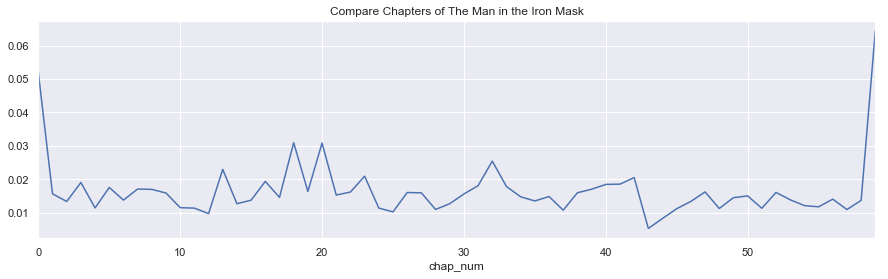

In [33]:
D.tf.plot(figsize=(15,4), title = 'Compare Chapters of The Man in the Iron Mask')

In [34]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [35]:
IM_P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
IM_P.index.names = ['doc_x','doc_y']

In [36]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [37]:
IM_P['euclidean'] = 0
IM_P['euclidean'] = IM_P.apply(euclidean, 1)

In [38]:
IM_PME = IM_P.euclidean.unstack().fillna(0)

In [39]:
IM_PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,50,51,52,53,54,55,56,57,58,59
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.15837,0.147971,0.135671,0.167079,0.173109,0.168413,0.127007,0.106587,0.104816,0.138474,...,0.125180,0.123376,0.103880,0.112493,0.148287,0.145152,0.122262,0.132327,0.132253,0.089135
1,0.00000,0.179190,0.176472,0.202605,0.213985,0.217232,0.188187,0.171446,0.169486,0.188761,...,0.179942,0.177751,0.165470,0.170814,0.190993,0.194938,0.177962,0.184581,0.186012,0.157519
2,0.00000,0.000000,0.127543,0.185676,0.199748,0.210521,0.179697,0.161342,0.159239,0.178135,...,0.172828,0.168624,0.157114,0.162137,0.188626,0.186968,0.169673,0.177648,0.177166,0.147090
3,0.00000,0.000000,0.000000,0.175491,0.187747,0.201332,0.168924,0.151062,0.147968,0.163571,...,0.161094,0.158860,0.145240,0.151126,0.178825,0.178049,0.159593,0.167688,0.167486,0.135489
4,0.00000,0.000000,0.000000,0.000000,0.188193,0.221669,0.194679,0.179456,0.178155,0.196075,...,0.187119,0.186019,0.175446,0.180284,0.203092,0.203375,0.186635,0.193670,0.193696,0.167079


In [40]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [41]:
IM_P['cosine'] = IM_P.apply(cosine, 1)
IM_PMC = IM_P.cosine.unstack().fillna(0)
IM_PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,50,51,52,53,54,55,56,57,58,59
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.000262,0.000292,0.000328,0.000317,0.000283,0.000866,0.000956,0.000473,0.000449,0.000250,...,0.000292,0.000270,0.000297,0.000259,0.000264,0.000302,0.000232,0.000305,0.000288,0.000297
1,0.000000,0.001713,0.001302,0.001197,0.000472,0.000343,0.000295,0.000157,0.000188,0.000288,...,0.000274,0.000339,0.000309,0.000287,0.000741,0.000231,0.000213,0.000322,0.000177,0.000242
2,0.000000,0.000000,0.003986,0.001959,0.001070,0.000297,0.000308,0.000227,0.000261,0.000452,...,0.000154,0.000361,0.000221,0.000248,0.000260,0.000231,0.000179,0.000196,0.000217,0.000270
3,0.000000,0.000000,0.000000,0.002261,0.001491,0.000406,0.000415,0.000189,0.000286,0.000844,...,0.000278,0.000326,0.000275,0.000268,0.000318,0.000200,0.000160,0.000208,0.000206,0.000251
4,0.000000,0.000000,0.000000,0.000000,0.003782,0.000620,0.000443,0.000209,0.000193,0.000345,...,0.000378,0.000354,0.000216,0.000218,0.000366,0.000151,0.000184,0.000227,0.000205,0.000228


## Cosine Similarity

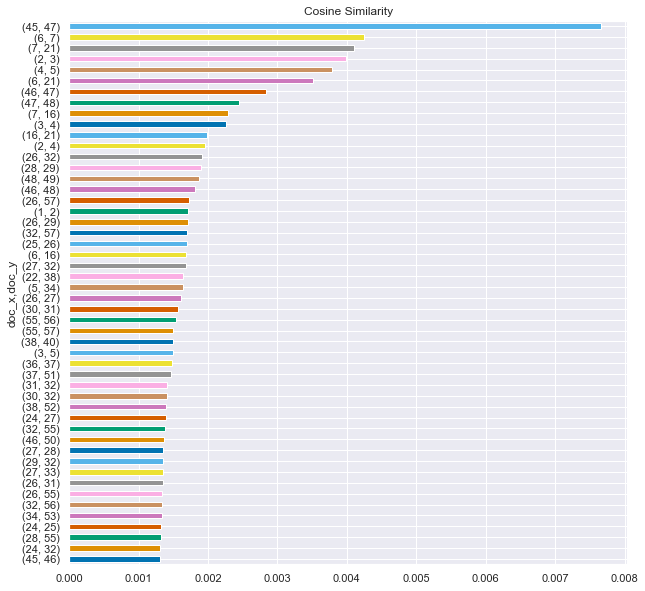

In [42]:
IM_P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', color=sns.color_palette('colorblind'), figsize=(10,10), title = 'Cosine Similarity')

## Compare Euclidean and Cosine Metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


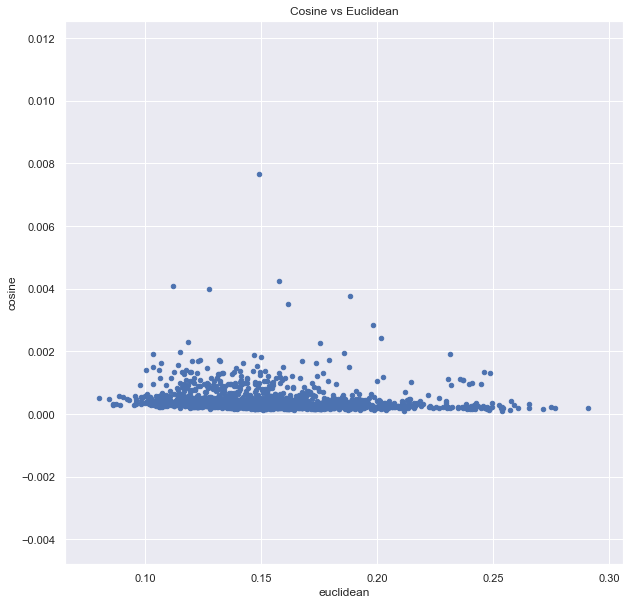

In [43]:
IM_P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10), title='Cosine vs Euclidean')

In [44]:
import matplotlib.pyplot as plt

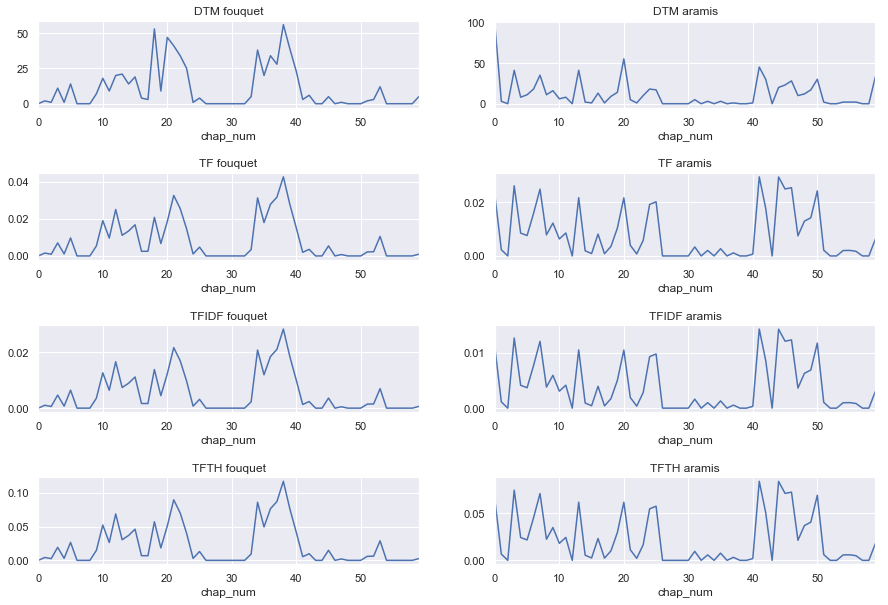

In [45]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('fouquet aramis'.split()):
    W = get_term_id(IM_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

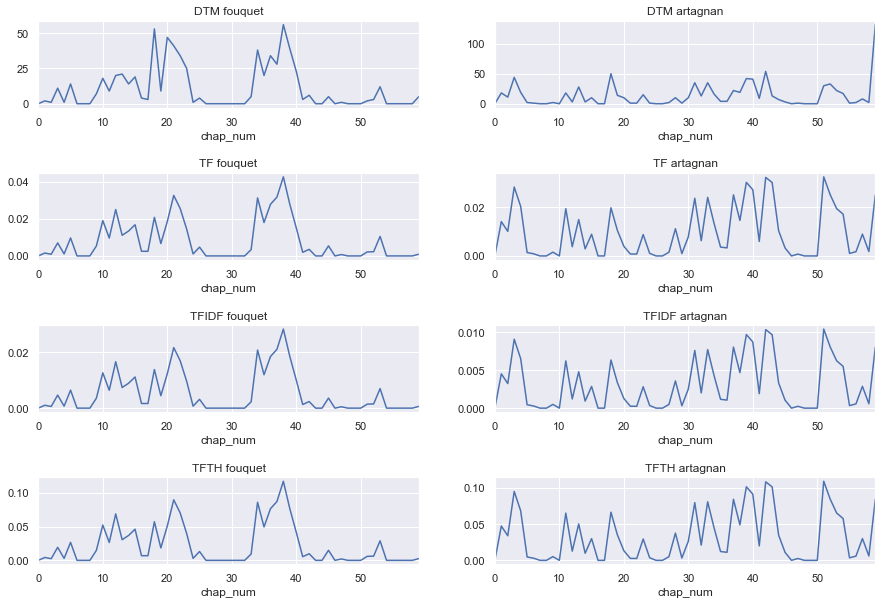

In [46]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('fouquet artagnan'.split()):
    W = get_term_id(IM_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

In [47]:
IM_V.to_csv('The_Man_in_the_Iron_Mask.csv', index=False)

## Visualize KDE Plots

In [48]:
IM_K.head()

pos token_str  punc  num  term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0           NN   Chapter     0    0   chapter   
                           1          PRP         I     0    0         i   
                  1        0           DT       The     0    0       the   
                           1          NNP  Prisoner     0    0  prisoner   
         1        0        0           IN     Since     0    0     since   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             1433  
                           1             4567  
                  1        0             9073  
                           1             7018  
         1        0        0             8289

In [49]:
lmk = IM_K.copy()

In [50]:
tt = lmk[['term_str','term_id']]
tt.head()

term_str  term_id
chap_num para_num sent_num token_num                   
0        0        0        0           chapter     1433
                           1                 i     4567
                  1        0               the     9073
                           1          prisoner     7018
         1        0        0             since     8289

In [51]:
K = tt.reset_index()

In [52]:
K.rename_axis('offset', inplace=True)

In [53]:
K = K[['term_str','term_id']]
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_str,chapter,i,the,prisoner,since,aramis,s,singular,transformation,into,a
term_id,1433,4567,9073,7018,8289,459,7854,8297,9293,4950,0


In [54]:
vocab_weight = 'tfidf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 5000
kde_samples = 1000

In [55]:
V1 = IM_V[(IM_V[vocab_weight] > IM_V[vocab_weight].quantile(vocab_weight_quantile)) & (IM_V.n >= vocab_min_n)]

In [56]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,6847,7270,610,3788,723,949,1625,8306,459,5877
term_str,porthos,raoul,athos,fouquet,baisemeaux,biscarrat,colbert,sire,aramis,moliere
n,437,259,248,638,136,79,247,169,710,79
p,0.0025185,0.00149266,0.00142926,0.00367689,0.000783789,0.000455289,0.0014235,0.000973974,0.00409184,0.000455289
port_stem,portho,raoul,atho,fouquet,baisemeaux,biscarrat,colbert,sire,arami,molier
stop,0,0,0,0,0,0,0,0,0,0
df,32,18,20,38,8,4,22,16,43,7
tf_sum,0.375718,0.196093,0.212209,0.477,0.0995698,0.0669457,0.169828,0.121486,0.473795,0.0667431
tf_mean,0.00626197,0.00326822,0.00353681,0.00795001,0.0016595,0.00111576,0.00283046,0.00202476,0.00789659,0.00111239
tf_max,0.0341878,0.0313453,0.0249219,0.0427478,0.0318863,0.0413531,0.0288806,0.0236639,0.0295856,0.0320167
tfidf_sum,0.340735,0.340607,0.336343,0.314326,0.289438,0.261549,0.245819,0.23166,0.227718,0.206873


In [57]:
TOP_TERMS = IM_V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [58]:
TOP_TERMS

['porthos',
 'raoul',
 'athos',
 'fouquet',
 'baisemeaux',
 'biscarrat',
 'colbert',
 'sire',
 'aramis',
 'moliere',
 'planchet',
 'percerin',
 'artagnan',
 'monseigneur',
 'comte',
 'madame',
 'governor',
 'pelisson',
 'mouston',
 'prisoner',
 'gourville',
 'officer',
 'mademoiselle',
 'grimaud',
 'grotto',
 'cavern',
 'majesty',
 'philippe',
 'tailor',
 'duchesse']

In [59]:
K = K[K.term_id.isin(V1.index)]

In [60]:
K.head(11).T

offset,3,5,15,18,27,29,31,34,35,48,60
term_str,prisoner,aramis,baisemeaux,longer,place,aramis,held,worthy,governor,friend,felt
term_id,7018,459,723,5448,6713,459,4369,10037,4087,3838,3512


In [61]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [62]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [63]:
B.head()

,offset,x
term_str,,
able,"[1252, 3438, 5980, 9153, 10456, 11359, 17198, ...","[[1252], [3438], [5980], [9153], [10456], [113..."
accompanied,"[2788, 15203, 25515, 27355, 30750, 37044, 3759...","[[2788], [15203], [25515], [27355], [30750], [..."
according,"[410, 18496, 19669, 29642, 37164, 42233, 69752...","[[410], [18496], [19669], [29642], [37164], [4..."
account,"[4488, 6351, 19927, 29328, 29733, 30816, 38925...","[[4488], [6351], [19927], [29328], [29733], [3..."
accustomed,"[3210, 14766, 22935, 24119, 24625, 29435, 3147...","[[3210], [14766], [22935], [24119], [24625], [..."


In [64]:
from sklearn.neighbors import KernelDensity as KDE
scale_max = K.index.max()
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

In [65]:
B.head()

,offset,x,kde,scores
term_str,,,,
able,"[1252, 3438, 5980, 9153, 10456, 11359, 17198, ...","[[1252], [3438], [5980], [9153], [10456], [113...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.565151735905445, -12.537363854645708, -12..."
accompanied,"[2788, 15203, 25515, 27355, 30750, 37044, 3759...","[[2788], [15203], [25515], [27355], [30750], [...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.838269793417608, -12.818481117143552, -12..."
according,"[410, 18496, 19669, 29642, 37164, 42233, 69752...","[[410], [18496], [19669], [29642], [37164], [4...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.65686146806166, -12.654410540357896, -12...."
account,"[4488, 6351, 19927, 29328, 29733, 30816, 38925...","[[4488], [6351], [19927], [29328], [29733], [3...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.85354860992232, -12.817734877128263, -12...."
accustomed,"[3210, 14766, 22935, 24119, 24625, 29435, 3147...","[[3210], [14766], [22935], [24119], [24625], [...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.884690306504998, -12.861694021377467, -12..."


In [66]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

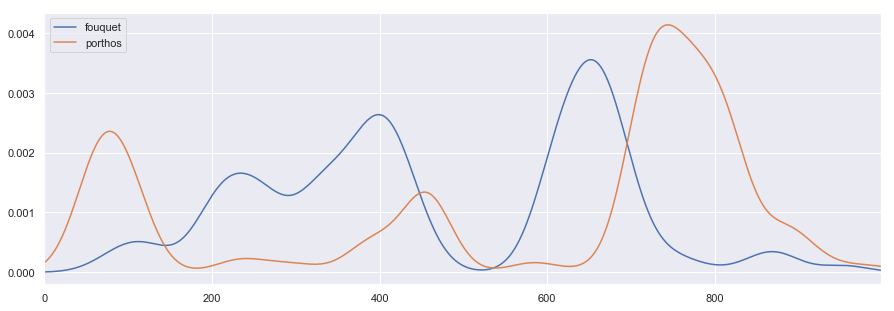

In [67]:
FIG = dict(figsize=(15, 5))
PLOTS.loc['fouquet'].plot(**FIG)
PLOTS.loc['porthos'].plot(**FIG)
plt.legend(loc='upper left') 

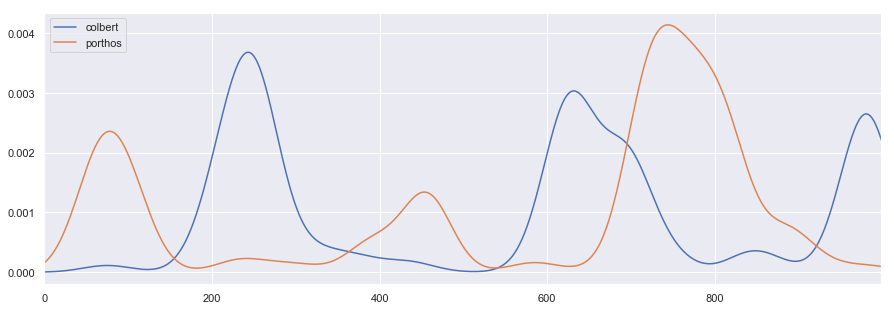

In [68]:
PLOTS.loc['colbert'].plot(**FIG)
PLOTS.loc['porthos'].plot(**FIG)
plt.legend(loc='upper left') 

## Compute TFIDF

In [69]:
WORDS = (IM_K.punc == 0) & (IM_K.num == 0) & IM_K.term_id.isin(IM_V[IM_V.stop==0].index)

In [70]:
BOW = IM_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [71]:
DTM = BOW.unstack().fillna(0)

In [72]:
alpha = .000001 
alpha_sum = alpha * IM_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [73]:
N_docs = DTM.shape[0]
IM_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / IM_V[IM_V.stop==0]['df'])

In [74]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,10128,10129,10134,10135,10136,10137,10138,10139,10140,10141
chap_num,,,,,,,,,,,,,,,,,,,,,
0,8.399611e-10,6.810880e-10,1.383992e-09,1.149691e-09,1.149691e-09,3.113328e-03,1.383992e-09,1.383992e-09,1.383992e-09,1.383992e-09,...,4.508128e-03,1.012633e-09,2.131471e-03,1.383992e-09,1.383992e-09,1.383992e-09,1.012633e-09,7.262250e-10,1.383992e-09,1.383992e-09
1,2.794181e-09,2.265680e-09,4.603932e-09,3.824515e-09,3.824515e-09,2.589168e-09,4.603932e-09,4.603932e-09,4.603932e-09,4.603932e-09,...,3.487572e-10,3.368585e-09,1.418093e-09,4.603932e-09,4.603932e-09,4.603932e-09,3.368585e-09,2.415831e-09,4.603932e-09,4.603932e-09
2,3.273908e-09,2.654670e-09,5.394371e-09,4.481138e-09,4.481138e-09,3.033697e-09,5.394371e-09,5.394371e-09,5.394371e-09,5.394371e-09,...,4.086346e-10,3.946930e-09,1.661563e-09,5.394371e-09,5.394371e-09,5.394371e-09,3.946930e-09,2.830600e-09,5.394371e-09,5.394371e-09
3,2.295096e-09,1.860994e-09,3.781596e-09,3.141395e-09,3.141395e-09,2.126701e-09,3.781596e-09,3.781596e-09,3.781596e-09,3.781596e-09,...,2.864639e-04,2.766902e-09,1.164799e-09,3.781596e-09,3.781596e-09,3.781596e-09,2.766902e-09,1.984325e-09,3.781596e-09,3.781596e-09
4,3.825960e-09,3.102305e-09,6.303978e-09,5.236754e-09,5.236754e-09,3.545243e-09,6.303978e-09,6.303978e-09,6.303978e-09,6.303978e-09,...,4.775392e-10,4.612467e-09,1.941738e-09,6.303978e-09,6.303978e-09,6.303978e-09,4.612467e-09,3.307900e-09,6.303978e-09,6.303978e-09


## Principal Component Analysis

In [75]:
def get_pca(df, k=2):
    from sklearn.decomposition import PCA
    pca = PCA(k)
    X = pd.DataFrame(pca.fit_transform(df))
    X.index = df.index.tolist()
    return X

In [76]:
pca1 = get_pca(TFIDF, k=2)
pca1

,0,1
0,-0.004516,-0.005534
1,-0.008970,-0.007728
2,-0.009278,-0.016670
3,-0.010848,-0.014675
4,-0.015462,-0.020003
5,-0.014199,-0.027294
6,-0.016187,-0.031184
7,-0.012623,-0.020567
8,-0.003807,-0.004124
9,-0.003638,-0.005594


In [77]:
X = np.array(pca1)
X

array([[-4.51573088e-03, -5.53449790e-03],
       [-8.97022588e-03, -7.72813684e-03],
       [-9.27754629e-03, -1.66704294e-02],
       [-1.08475833e-02, -1.46747557e-02],
       [-1.54621660e-02, -2.00026382e-02],
       [-1.41991973e-02, -2.72944932e-02],
       [-1.61872139e-02, -3.11842051e-02],
       [-1.26230061e-02, -2.05673581e-02],
       [-3.80692826e-03, -4.12398069e-03],
       [-3.63750432e-03, -5.59354486e-03],
       [-5.94267194e-03, -9.19112213e-03],
       [-6.11361700e-03, -8.21597233e-03],
       [-6.32245415e-03, -9.13399107e-03],
       [-5.82798017e-03, -7.34690407e-03],
       [-4.79956550e-03, -8.50016811e-03],
       [-4.67088158e-03, -6.56191275e-03],
       [-7.25424138e-03, -1.01889531e-02],
       [-5.62372763e-03, -8.04706355e-03],
       [-4.25830976e-03, -6.33063770e-03],
       [-4.14917127e-03, -5.06239648e-03],
       [-4.79348300e-03, -4.18056038e-03],
       [-1.13701529e-02, -1.84258554e-02],
       [-6.74047733e-03, -8.55758444e-03],
       [-4.

In [78]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [79]:
print(pca.components_)

[[1. 0.]
 [0. 1.]]


In [80]:
print(pca.explained_variance_)

[0.00085699 0.00073021]


In [81]:
print(pca.mean_)

[-1.22153445e-18  1.24321849e-18]


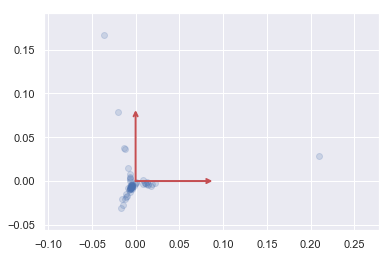

In [82]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Sentiment Analysis

In [83]:
import sqlite3

In [84]:
# Developed in other notebook
lex_db = 'lexicon/lexicons.db'

In [86]:
text_db = 'db/The_Man_in_the_Iron_Mask.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

emo = 'bing_sentiment'
#emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [87]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

In [88]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [89]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [90]:
emo_cols = combo.columns

In [91]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'gi_sentiment'],
      dtype='object')

In [92]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

In [93]:
tokens = tokens.join(combo, on='term_str', how='left')

In [94]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
57        4         6         2           NaN
3         21        1         17          NaN
42        22        0         17          NaN
52        55        28        23          NaN
25        42        1         18          NaN
40        24        1         1           NaN
0         282       1         25          NaN
44        29        0         3           NaN
56        16        2         47          NaN
3         116       0         19          NaN
Name: bing_sentiment, dtype: float64

In [95]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [96]:
tokens.head(10)

pos       token_str  punc  num  \
chap_num para_num sent_num token_num                                   
0        0        0        0           NN         Chapter     0    0   
                           1          PRP               I     0    0   
                  1        0           DT             The     0    0   
                           1          NNP        Prisoner     0    0   
         1        0        0           IN           Since     0    0   
                           1          NNP          Aramis     0    0   
                           3          VBD               s     0    0   
                           4           JJ        singular     0    0   
                           5           NN  transformation     0    0   
                           6           IN            into     0    0   

                                            term_str  term_id  nrc_anger  \
chap_num para_num sent_num token_num                                       
0        0        0        0                 chapter     1433        0.0   
                           1                       i     4567        0.0   
                  1        0                     the     9073        0.0   
                           1                prisoner     7018        1.0   
         1        0        0                   since     8289        0.0   
                           1                  aramis      459        0.0   
                           3                       s     7854        0.0   
                           4                singular     8297        0.0   
                           5          transformation     9293        0.0   
                           6                    into     4950        0.0   

                                      nrc_anticipation  nrc_disgust  nrc_fear  \
chap_num para_num sent_num token_num                                            
0        0        0        0                       0.0          0.0       0.0   
                           1                       0.0          0.0       0.0   
                  1        0                       0.0          0.0       0.0   
                           1                       0.0          1.0       1.0   
         1        0        0                       0.0          0.0       0.0   
                           1                       0.0          0.0       0.0   
                           3                       0.0          0.0       0.0   
                           4                       0.0          0.0       0.0   
                           5                       0.0          0.0       0.0   
                           6                       0.0          0.0       0.0   

                                      nrc_joy  nrc_negative  nrc_positive  \
chap_num para_num sent_num token_num                                        
0        0        0        0              0.0           0.0           0.0   
                           1              0.0           0.0           0.0   
                  1        0              0.0           0.0           0.0   
                           1              0.0           1.0           0.0   
         1        0        0              0.0           0.0           0.0   
                           1              0.0           0.0           0.0   
                           3              0.0           0.0           0.0   
                           4              0.0           0.0           0.0   
                           5              0.0           0.0           0.0   
                           6              0.0           0.0           0.0   

                                      nrc_sadness  nrc_surprise  nrc_trust  \
chap_num para_num sent_num token_num                                         
0        0        0        0                  0.0           0.0        0.0   
                           1                  0.0           0.0        0.0   
                  1        0                  0.0 

In [97]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)

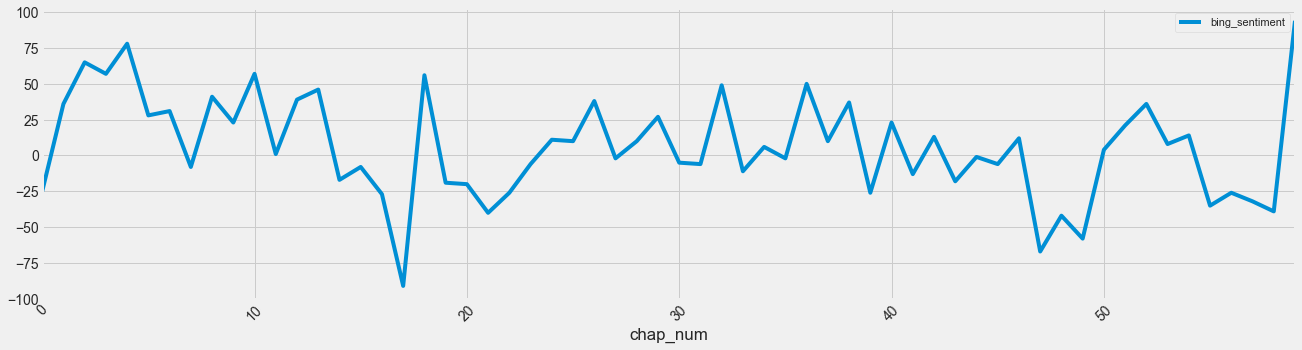

In [98]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

In [99]:
by_chaps= tokens.groupby(CHAPS)[emo_cols].sum()

In [100]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [101]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0              <span class='sent0'>Chapter</span>
                              1                    <span class='sent0'>I</span>
                    1         0                  <span class='sent0'>The</span>
                              1            <span class='sent-1'>Prisoner</span>
          1         0         0                <span class='sent0'>Since</span>
Name: html, dtype: object

In [102]:
by_chaps['chaps_str'] = tokens.groupby(CHAPS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_chaps['html_str'] = tokens.groupby(CHAPS).html.apply(lambda x: x.str.cat(sep=' '))

In [103]:
by_chaps[['chaps_str', 'html_str']].head()

,chaps_str,html_str
chap_num,,
0,chapter i the prisoner since aramis s singular...,<span class='sent0'>Chapter</span> <span class...
1,chapter ii how mouston had become fatter witho...,<span class='sent0'>Chapter</span> <span class...
2,chapter iii who messire jean percerin was the ...,<span class='sent0'>Chapter</span> <span class...
3,chapter iv the patterns during all this time t...,<span class='sent0'>Chapter</span> <span class...
4,chapter v where probably moliere obtained his ...,<span class='sent0'>Chapter</span> <span class...


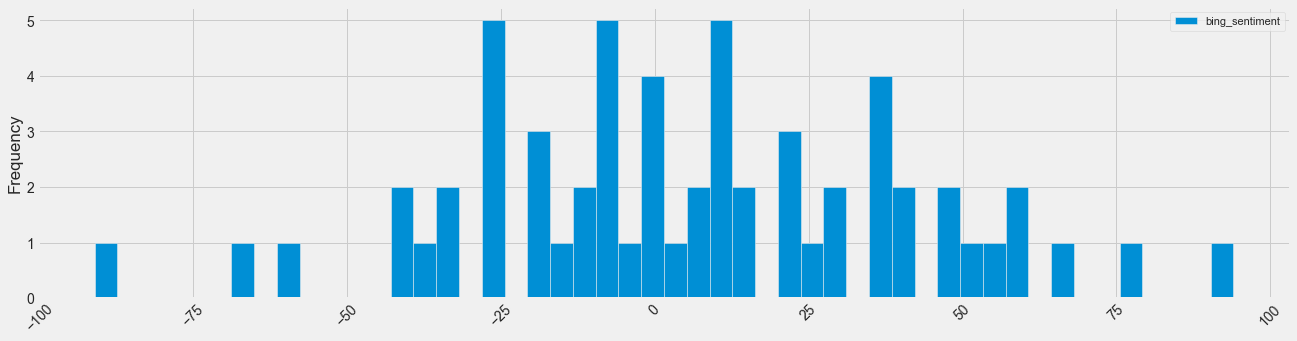

In [104]:
by_chaps[emo].plot.hist(**FIG, bins=50)

### Positive

In [105]:
by_chaps.sort_values(emo, ascending=False)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
59,94.0,chapter lx the last canto of the poem on the m...
4,78.0,chapter v where probably moliere obtained his ...
2,65.0,chapter iii who messire jean percerin was the ...
10,57.0,chapter xi the chateau de vaux le vicomte the ...
3,57.0,chapter iv the patterns during all this time t...
18,56.0,chapter xix the shadow of m fouquet d artagnan...
36,50.0,chapter xxxvii the two lighters d artagnan had...
32,49.0,chapter xxxiii promises scarcely had d artagna...
13,46.0,chapter xiv a gascon and a gascon and a half d...


### Negative

In [106]:
by_chaps.sort_values(emo, ascending=True)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
17,-91.0,chapter xviii a night at the bastile pain angu...
47,-67.0,chapter xlviii the grotto in spite of the sort...
49,-58.0,chapter l the death of a titan at the moment w...
48,-42.0,chapter xlix an homeric song it is time to pas...
21,-40.0,chapter xxii showing how the countersign was r...
58,-39.0,chapter lix the bulletin the duc de beaufort w...
55,-35.0,chapter lvi the old age of athos while these a...
57,-32.0,chapter lviii the angel of death athos was at ...
16,-27.0,chapter xvii high treason the ungovernable fur...


### Multinomial Emotions

In [107]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [108]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.0,-1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


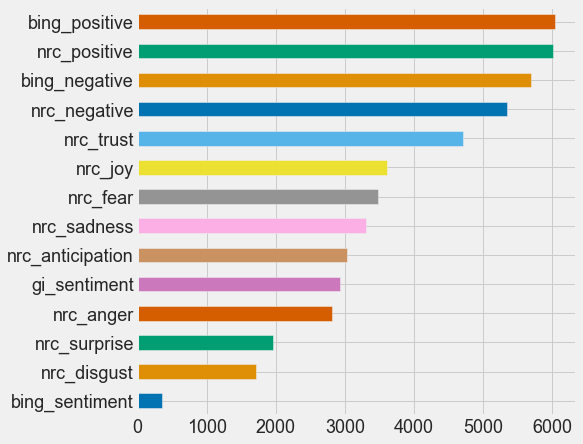

In [109]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18, color=sns.color_palette('colorblind'))

### Visualize KDE for Emotions

In [110]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [111]:
B.head()

,x
emo,
nrc_anger,"[[3], [144], [278], [299], [414], [428], [472]..."
nrc_anticipation,"[[100], [123], [168], [263], [301], [379], [39..."
nrc_disgust,"[[3], [144], [278], [299], [414], [472], [486]..."
nrc_fear,"[[3], [144], [224], [265], [278], [299], [301]..."
nrc_joy,"[[48], [56], [100], [123], [168], [173], [263]..."


In [112]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

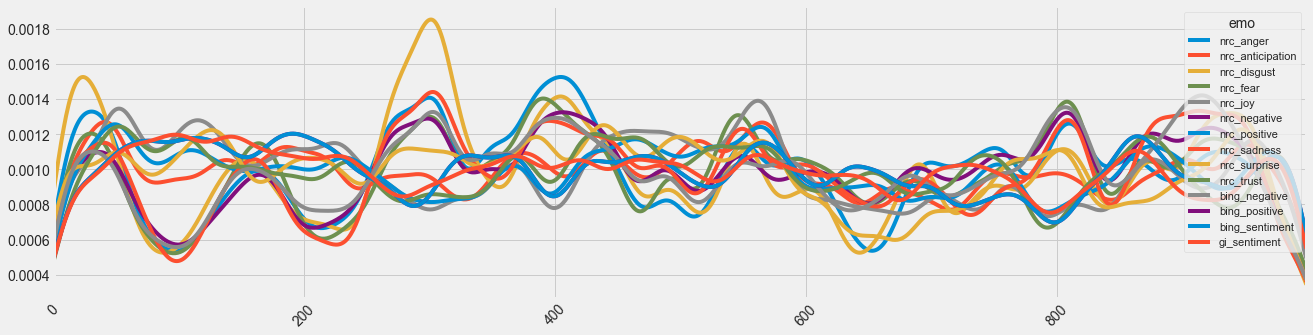

In [113]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T
PLOTS.plot(**FIG)

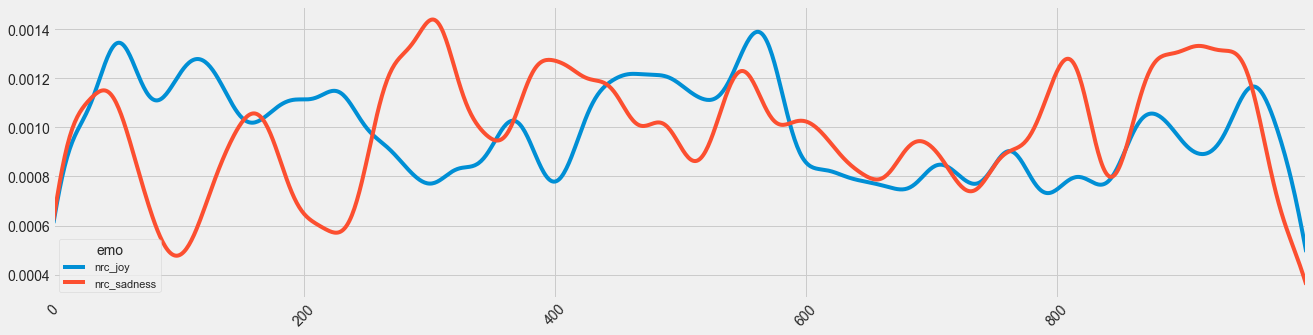

In [114]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

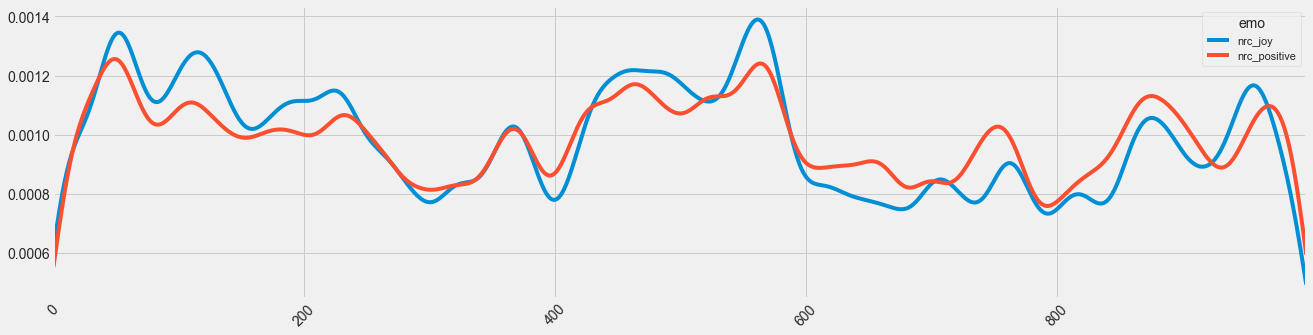

In [115]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

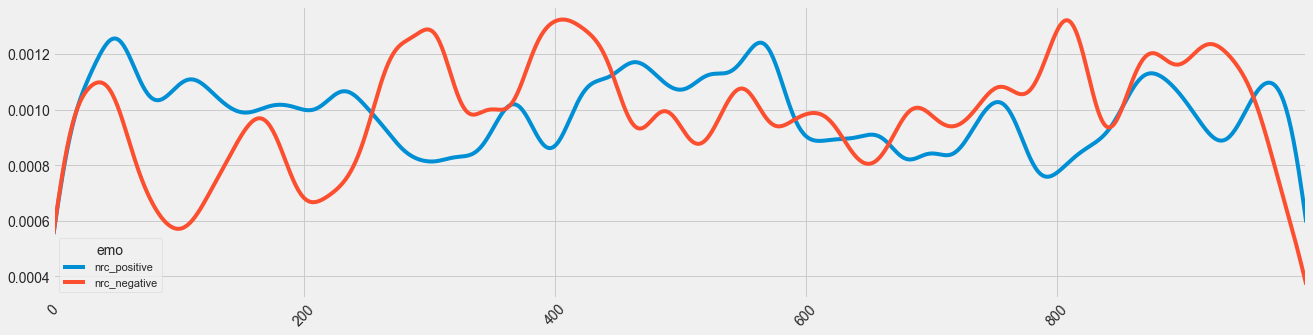

In [116]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

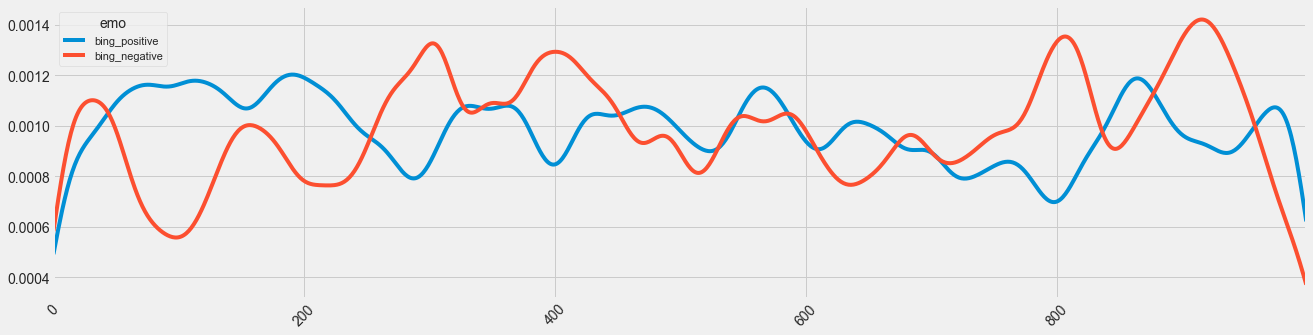

In [117]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)